# Prostate data

In [12]:
# Loading prostate data
prostate <- read.csv("http://www.uio.no/studier/emner/matnat/math/STK2100/data/prostate.data",sep="\t",header=TRUE)
prostate <- prostate[, -1] # remove first column
prostate$svi <- as.factor(prostate$svi) # convert to factor

# Fitting model
fit.lm <- lm(lpsa ~ . - train, data = prostate, subset = (train == TRUE))
summary(fit.lm)


Call:
lm(formula = lpsa ~ . - train, data = prostate, subset = (train == 
    TRUE))

Residuals:
     Min       1Q   Median       3Q      Max 
-1.64870 -0.34147 -0.05424  0.44941  1.48675 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.429170   1.553588   0.276  0.78334    
lcavol       0.576543   0.107438   5.366 1.47e-06 ***
lweight      0.614020   0.223216   2.751  0.00792 ** 
age         -0.019001   0.013612  -1.396  0.16806    
lbph         0.144848   0.070457   2.056  0.04431 *  
svi1         0.737209   0.298555   2.469  0.01651 *  
lcp         -0.206324   0.110516  -1.867  0.06697 .  
gleason     -0.029503   0.201136  -0.147  0.88389    
pgg45        0.009465   0.005447   1.738  0.08755 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7123 on 58 degrees of freedom
Multiple R-squared:  0.6944,	Adjusted R-squared:  0.6522 
F-statistic: 16.47 on 8 and 58 DF,  p-value: 2.042e-12


In [13]:
library(glmnet)

Loading required package: Matrix

Loaded glmnet 4.1-8



In [19]:
# standardise numerical covariates
p <- 8
prostate.std <- prostate[, -10] # removing indicator of train/test

for (j in 1:p) {
    if(!is.factor(prostate[, j])) {
        prostate.std[, j] <- (prostate.std[, j] - mean(prostate.std[, j])) / sd(prostate.std[, j])
    }
}

X <- model.matrix(lpsa ~ . , data = prostate.std)[, -1] # without intercept
y <- prostate.std$lpsa

### Ridge regression


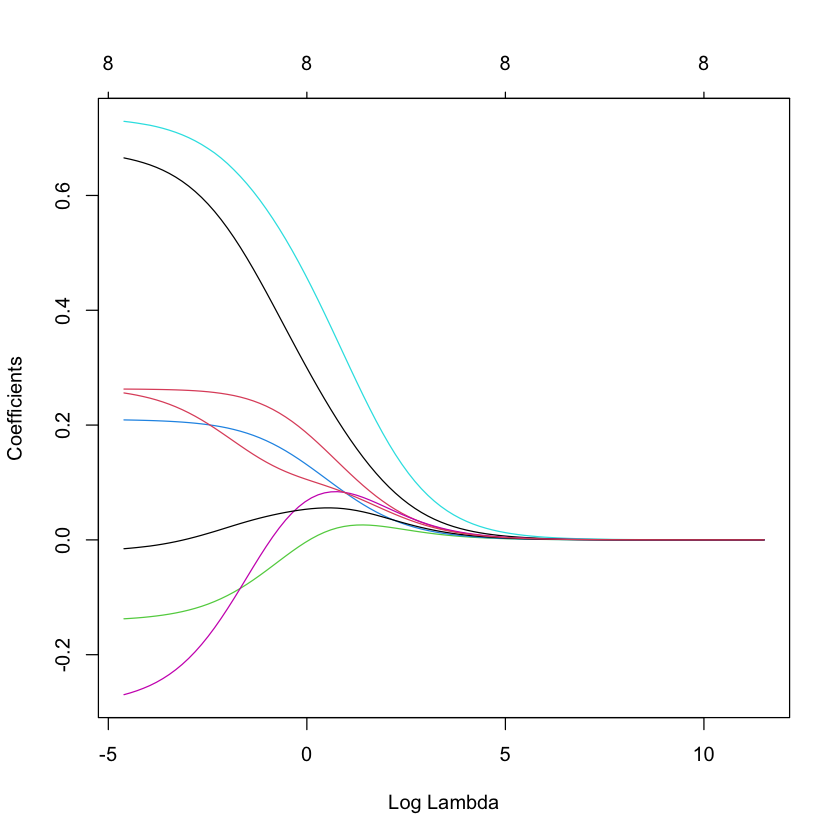

In [ ]:

# Fit ridge regression models for a range of lambda values
lambda.grid = 10^seq(5, -2, length = 100)
fit.ridge <- glmnet(X[prostate$train == TRUE, ], y[prostate$train == TRUE], lambda = lambda.grid, alpha = 0)

par(bg = "white")
plot(fit.ridge, xvar="lambda")

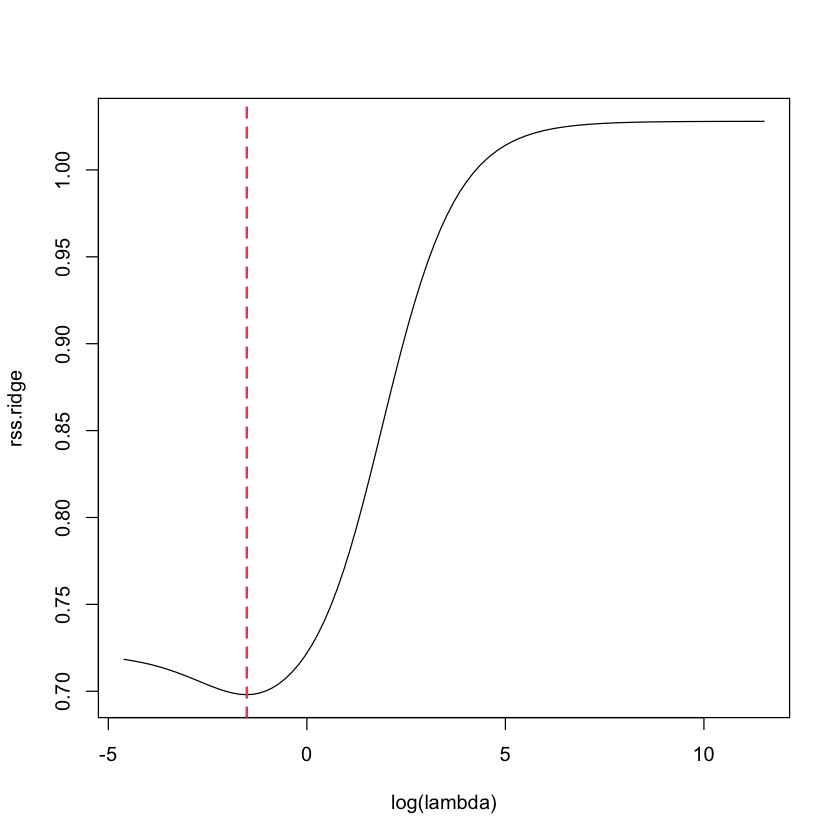

In [25]:
# looking at RSS for each lambda value

rss.ridge <- rep(NA, length(lambda.grid)) # calc RSS for each value of lambda
for (k in 1:length(lambda.grid)) {
    pred.ridge <- predict(fit.ridge, s = lambda.grid[k], newx = X[prostate$train == FALSE,])
    rss.ridge[k] <- sqrt(mean((pred.ridge - y[prostate$train == FALSE])^2))
}
par(bg = "white")
plot(log(lambda.grid), rss.ridge, type = "l", xlab = "log(lambda)")
abline(v = log(lambda.grid)[which.min(rss.ridge)], lty = 2, col = 2, lwd = 2)


In [27]:
# choose lambda with cross validation (k = 10 is default)
fit.ridge.cv <- cv.glmnet(X[prostate$train == TRUE,], y[prostate$train == TRUE], lambda = lambda.grid, alpha = 0)
fit.ridge.cv


Call:  cv.glmnet(x = X[prostate$train == TRUE, ], y = y[prostate$train ==      TRUE], lambda = lambda.grid, alpha = 0) 

Measure: Mean-Squared Error 

    Lambda Index Measure     SE Nonzero
min 0.0100   100  0.5287 0.1140       8
1se 0.9545    72  0.6388 0.1107       8

9 x 1 sparse Matrix of class "dgCMatrix"
                     s0
(Intercept)  2.30751216
lcavol       0.66544677
lweight      0.26274817
age         -0.13746116
lbph         0.20897950
svi1         0.72942081
lcp         -0.26978708
gleason     -0.01541664
pgg45        0.25599648

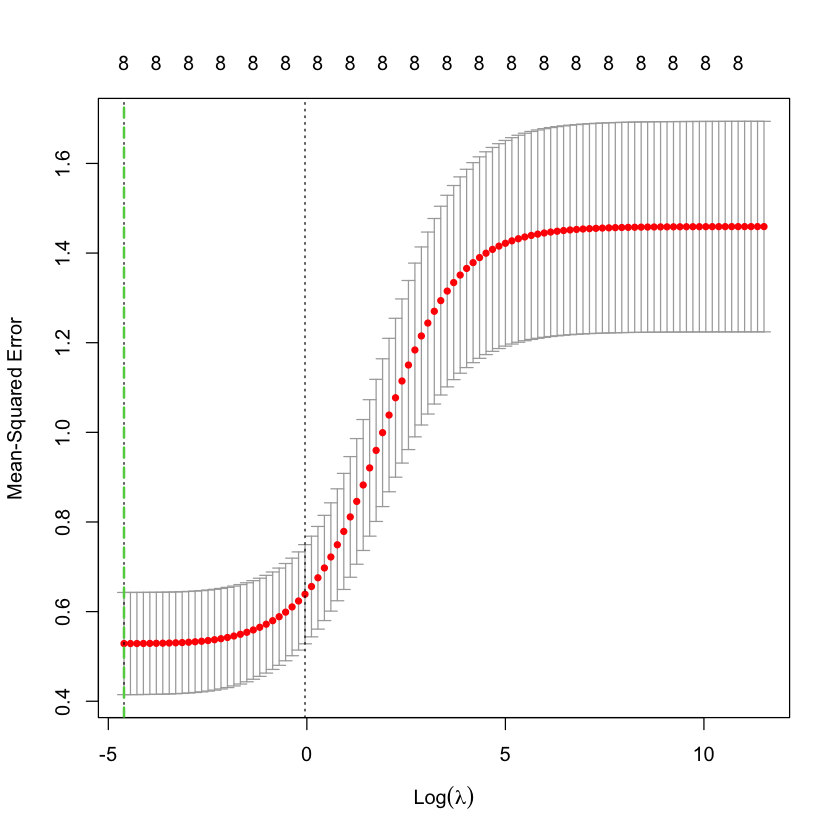

In [32]:
par(bg = "white")
plot(fit.ridge.cv)
abline(v = log(fit.ridge.cv$lambda.min), lty = 2, col = 3, lwd = 2)

fit.ridge.final <- glmnet(X[prostate$train == TRUE,], y[prostate$train == TRUE], lambda = fit.ridge.cv$lambda.min, alpha = 0)
coef(fit.ridge.final)


### Lasso regression


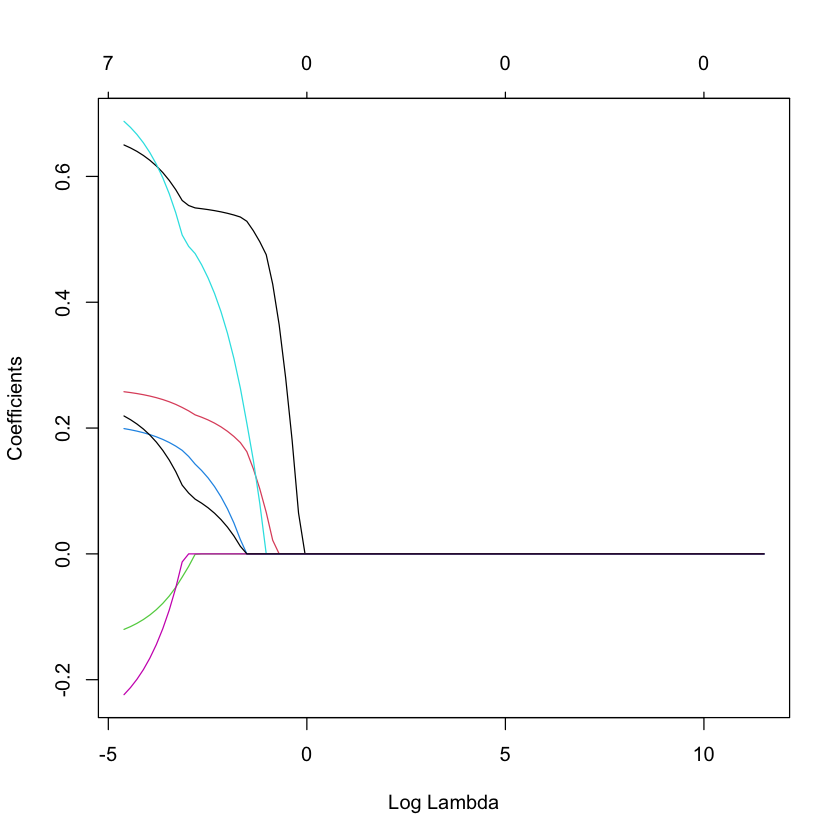

In [35]:
# Fit Lasso models for a range of lambdas
lambda.grid = 10^seq(5, -2, length = 100)
fit.lasso <- glmnet(X[prostate$train == TRUE,], y[prostate$train == TRUE], lambda = lambda.grid, alpha = 1)

par(bg = "white")
plot(fit.lasso, xvar = "lambda")

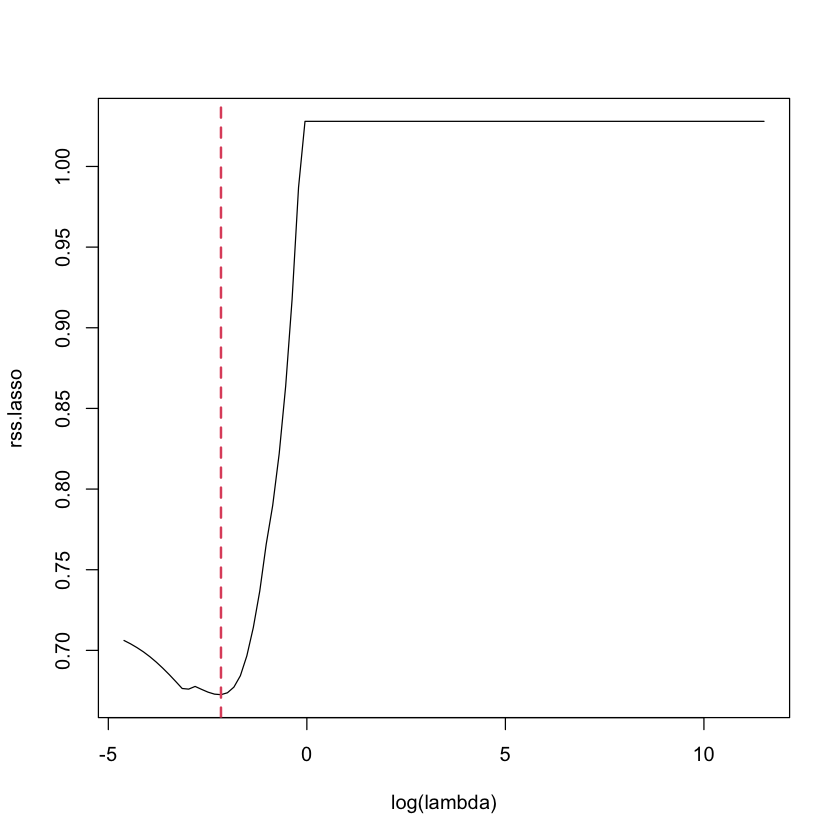

In [ ]:
rss.lasso <- rep(NA, length(lambda.grid)) # calculate RSS for each value of lambda

for (k in 1:length(lambda.grid)) {
    pred.lasso <- predict(fit.lasso, s = lambda.grid[k], newx = X[prostate$train == FALSE,])
    rss.lasso[k] <- sqrt(mean((pred.lasso - y[prostate$train == FALSE])^2))
}

par(bg = "white")
plot(log(lambda.grid), rss.lasso, type = "l", xlab = "log(lambda)")
abline(v = log(lambda.grid)[which.min(rss.lasso)], lty = 2, col = 2, lwd = 2)


Call:  cv.glmnet(x = X[prostate$train == TRUE, ], y = y[prostate$train ==      TRUE], lambda = lambda.grid, alpha = 1) 

Measure: Mean-Squared Error 

    Lambda Index Measure    SE Nonzero
min   1.56    69  111100 27468      17
1se  65.79    46  137641 27603       6

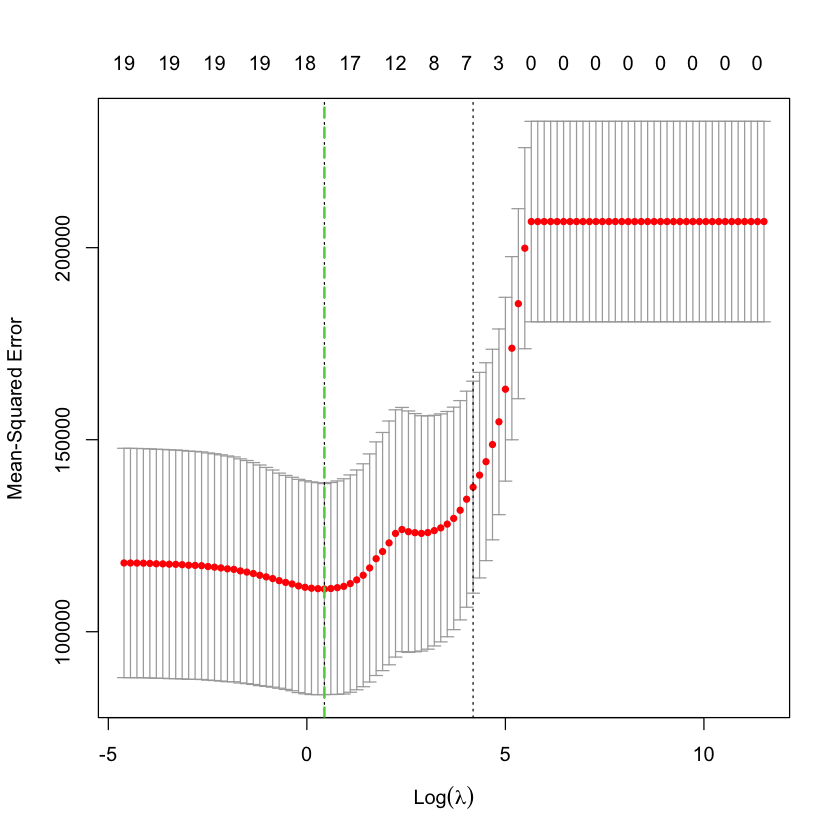

In [55]:
# Choose lambda with cross validation (K=10 as default)
fit.lasso.cv <- cv.glmnet(X[prostate$train == TRUE, ], y[prostate$train == TRUE], lambda=lambda.grid, alpha = 1)
fit.lasso.cv

par(bg = "white")
plot(fit.lasso.cv)
abline(v=log(fit.lasso.cv$lambda.min), lty = 2, col = 3, lwd = 2)

In [56]:
fit.lasso.final <- glmnet(X[prostate$train == TRUE,], y[prostate$train == TRUE], lambda = fit.lasso.cv$lambda.min, alpha = 1)
coef(fit.lasso.final)

20 x 1 sparse Matrix of class "dgCMatrix"
                    s0
(Intercept)  614.50621
AtBat       -403.07475
Hits         439.01796
HmRun          .      
Runs         -61.38208
RBI          -44.04568
Walks        187.98145
Years        -62.04295
CAtBat       -97.90231
CHits          .      
CHmRun       158.83015
CRuns        411.53770
CRBI          20.39335
CWalks      -210.49190
LeagueN       68.59118
DivisionW   -129.10101
PutOuts       89.91904
Assists       85.23012
Errors       -30.44434
NewLeagueN   -77.33758

### Principal Components regression


In [40]:
indices = c(1:4, 6:8) #numeric variables
Z = prcomp(prostate[, indices], retx = TRUE, scale = TRUE)$x
prostate.pca = data.frame(Z = Z, svi = prostate$svi, lpsa = prostate$lpsa)

# fit regression model to all principal components
fit.pca = lm(lpsa ~ . , data=prostate.pca[prostate$train == TRUE, ])
summary(fit.pca)


Call:
lm(formula = lpsa ~ ., data = prostate.pca[prostate$train == 
    TRUE, ])

Residuals:
     Min       1Q   Median       3Q      Max 
-1.64870 -0.34147 -0.05424  0.44941  1.48675 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.30533    0.11170  20.639  < 2e-16 ***
Z.PC1        0.33178    0.06425   5.164 3.09e-06 ***
Z.PC2        0.17028    0.07214   2.361  0.02163 *  
Z.PC3        0.31468    0.10032   3.137  0.00268 ** 
Z.PC4       -0.11494    0.11235  -1.023  0.31053    
Z.PC5       -0.03664    0.12327  -0.297  0.76737    
Z.PC6        0.43562    0.15860   2.747  0.00801 ** 
Z.PC7        0.55467    0.20519   2.703  0.00900 ** 
svi1         0.73721    0.29856   2.469  0.01651 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7123 on 58 degrees of freedom
Multiple R-squared:  0.6944,	Adjusted R-squared:  0.6522 
F-statistic: 16.47 on 8 and 58 DF,  p-value: 2.042e-12


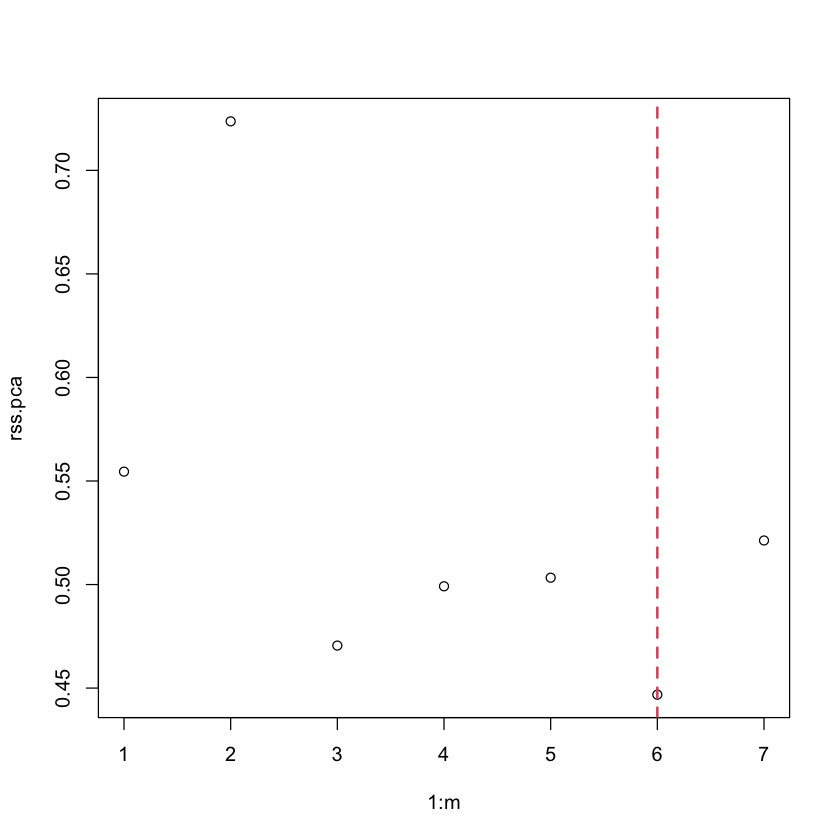

In [42]:
# fit regression model to PC in decreasing order
M <- ncol(Z)
rss.pca <- rep(0, M)
for (m in 1:M) {
    prostate.pca = data.frame(Z = Z[, 1:m], svi = prostate$svi, lpsa = prostate$lpsa)
    fit.pca = lm(lpsa ~ . , data = prostate.pca[prostate$train == TRUE, ])
    pred.pca = predict(fit.pca, newdata = prostate.pca[prostate$train == FALSE, ])
    rss.pca[m] = mean((prostate.pca$lpsa[prostate$train == FALSE] - pred.pca)^2)
}

par(bg = "white")
plot(1:m, rss.pca)
abline(v = which.min(rss.pca), col = 2, lty = 2, lwd = 2)

# Hitters data

In [43]:
library(ISLR)
data("Hitters")
hitters = na.omit(Hitters) # removing na-values

In [45]:
# standardise numerical covariates
p <- 19
hitters.std <- hitters

for (j in 1:(p+1)) {
    if((!is.factor(hitters[, j])) & (names(hitters)[j] != "Salary")) {
        hitters.std[, j] <- (hitters.std[, j] - mean(hitters.std[, j])) / sd(hitters.std[, j])
    }
}

X <- model.matrix(Salary ~ . , data = hitters.std)[, -1] # without intercept
y <- hitters.std$Salary

set.seed(1977)
train = sample(1:nrow(X), nrow(X) / 2)
test = (1:nrow(X))[-train]

### Ridge regression

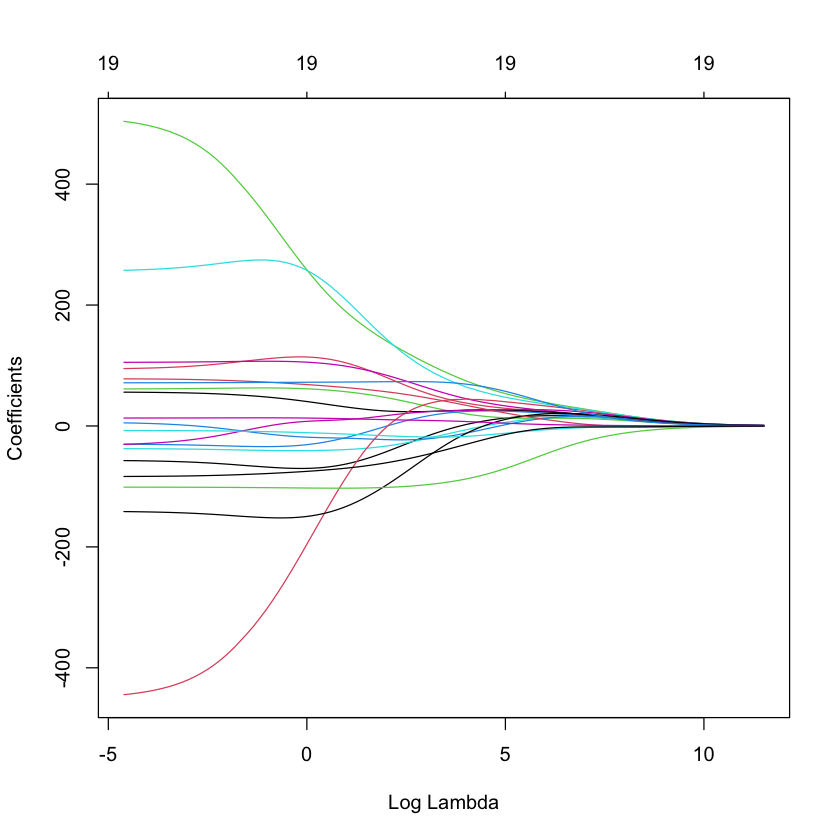

In [46]:
# fitting ridge regression models for a range of lambda values
lambda.grid = 10^seq(5, -2, length = 100)
fit.ridge <- glmnet(X[train, ], y[train], lambda = lambda.grid, alpha = 0)

par(bg = "white")
plot(fit.ridge, xvar = "lambda")

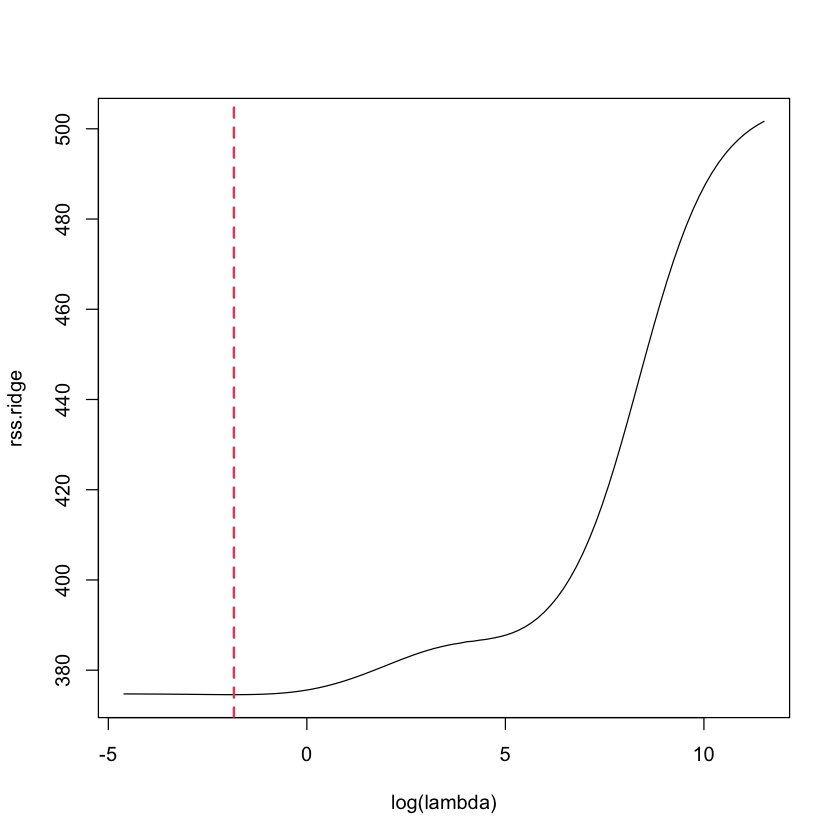

In [47]:
rss.ridge <- rep(NA, length(lambda.grid)) # calculate RSS
for (k in 1:length(lambda.grid)) {
    pred.ridge <- predict(fit.ridge, s = lambda.grid[k], newx = X[test, ])
    rss.ridge[k] <- sqrt(mean((pred.ridge - y[test])^2))
}

par(bg = "white")
plot(log(lambda.grid), rss.ridge, type = "l", xlab = "log(lambda)")
abline(v = log(lambda.grid)[which.min(rss.ridge)], lty = 2, col = 2, lwd = 2)


Call:  cv.glmnet(x = X[train, ], y = y[train], lambda = lambda.grid,      alpha = 0) 

Measure: Mean-Squared Error 

    Lambda Index Measure    SE Nonzero
min  335.2    36   85864  9272      19
1se 1707.4    26   93841 11850      19

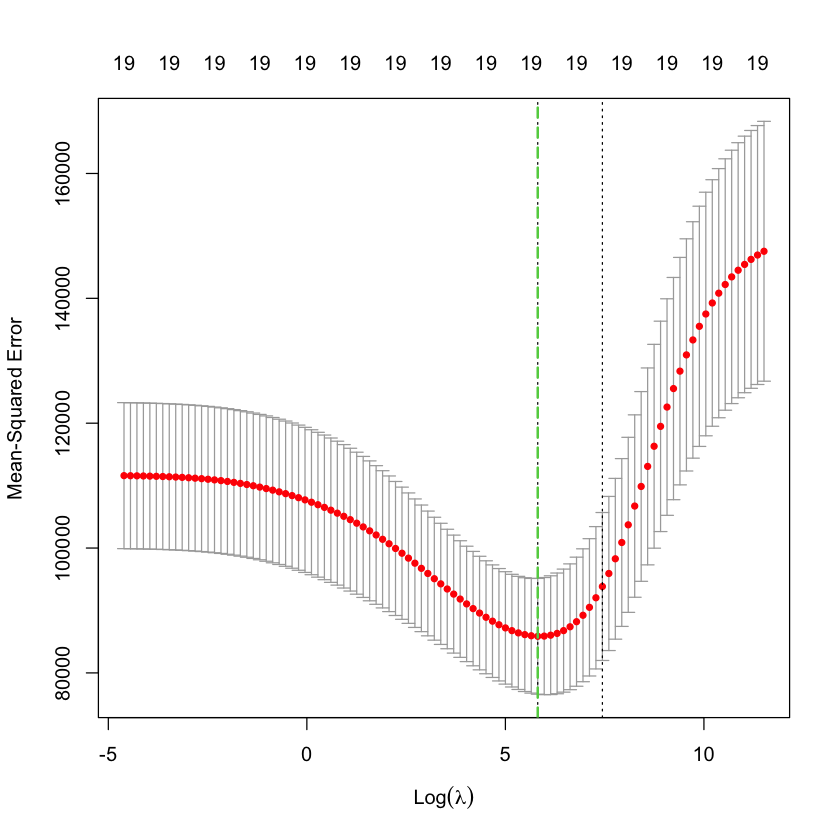

In [49]:
# Lambda with cross validation (K = 10 as default)
fit.ridge.cv <- cv.glmnet(X[train, ], y[train], lambda = lambda.grid, alpha = 0)
fit.ridge.cv

par(bg = "white")
plot(fit.ridge.cv)
abline(v = log(fit.ridge.cv$lambda.min), lty = 2, col = 3, lwd = 2)

In [50]:
fit.ridge.final <- glmnet(X[train, ], y[train], lambda = fit.ridge.cv$lambda.min, alpha = 0)
coef(fit.ridge.final)

20 x 1 sparse Matrix of class "dgCMatrix"
                    s0
(Intercept) 542.154100
AtBat        16.679660
Hits         24.421579
HmRun        12.798090
Runs         22.072313
RBI          12.379833
Walks        26.680241
Years        24.141699
CAtBat       34.584265
CHits        41.341432
CHmRun       11.331740
CRuns        38.165173
CRBI         26.970005
CWalks       19.053188
LeagueN      12.586690
DivisionW   -51.087672
PutOuts      42.477159
Assists      -7.206492
Errors        2.722663
NewLeagueN   -5.307418

### Lasso regression

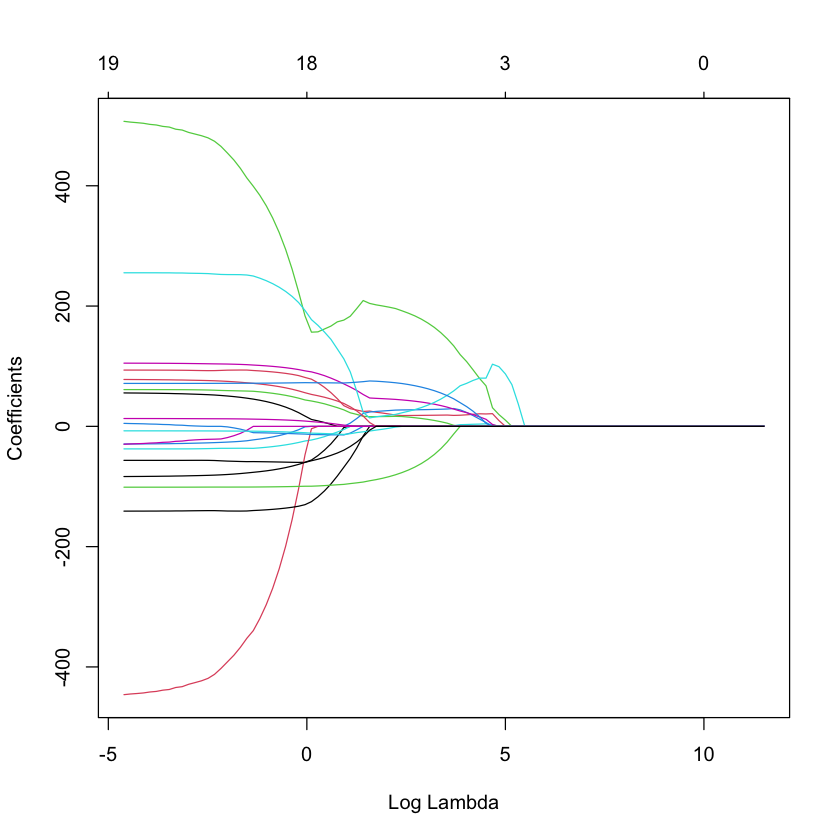

In [51]:
# Fit Lasso models for a range of lambdas
lambda.grid = 10^seq(5, -2, length = 100)
fit.lasso <- glmnet(X[train,], y[train], lambda = lambda.grid, alpha = 1)

par(bg = "white")
plot(fit.lasso, xvar = "lambda")

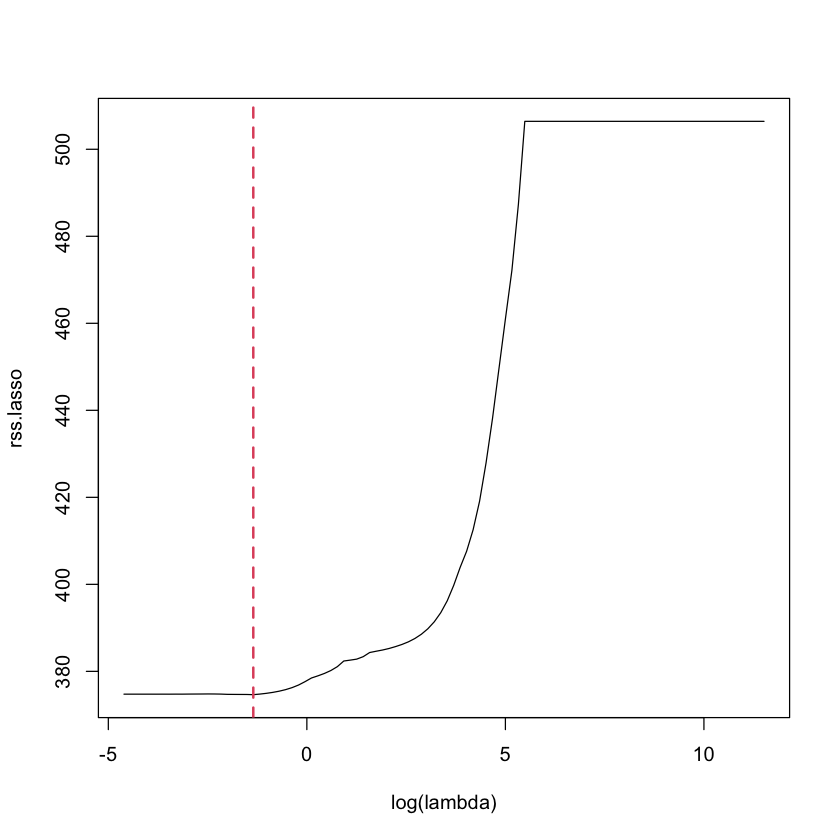

In [52]:
rss.lasso <- rep(NA, length(lambda.grid)) # calculate RSS for each value of lambda

for (k in 1:length(lambda.grid)) {
    pred.lasso <- predict(fit.lasso, s = lambda.grid[k], newx = X[test,])
    rss.lasso[k] <- sqrt(mean((pred.lasso - y[test])^2))
}

par(bg = "white")
plot(log(lambda.grid), rss.lasso, type = "l", xlab = "log(lambda)")
abline(v = log(lambda.grid)[which.min(rss.lasso)], lty = 2, col = 2, lwd = 2)


Call:  cv.glmnet(x = X[train, ], y = y[train], lambda = lambda.grid,      alpha = 1) 

Measure: Mean-Squared Error 

    Lambda Index Measure    SE Nonzero
min  21.05    53   93762 18573       8
1se 107.23    43  108842 16192       5

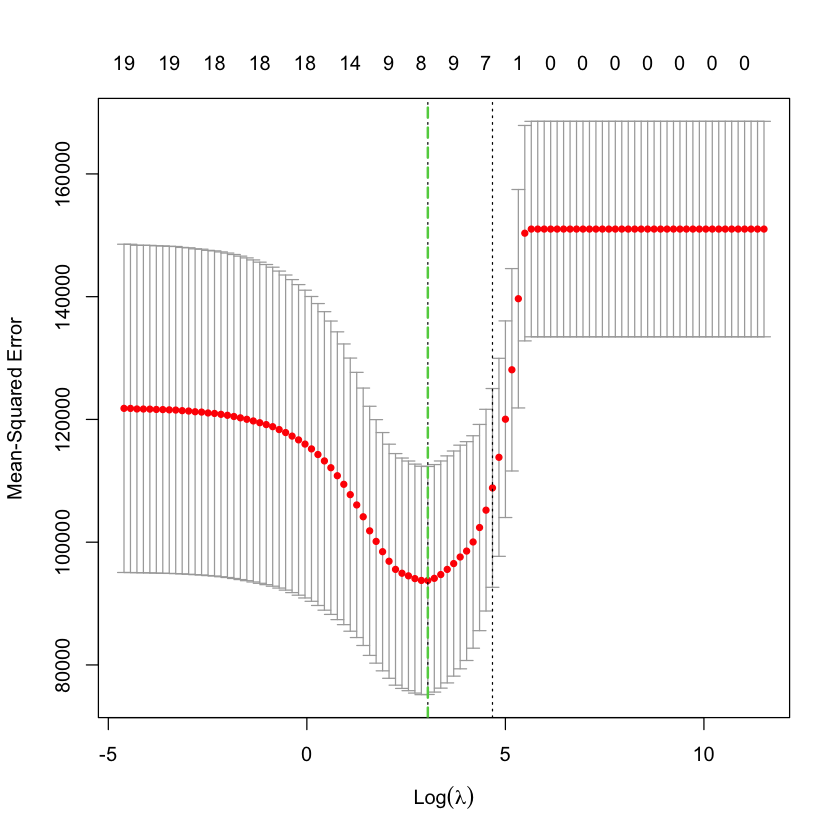

In [58]:
# Choose lambda with cross validation (K=10 as default)
fit.lasso.cv <- cv.glmnet(X[train,], y[train], lambda = lambda.grid, alpha = 1)
fit.lasso.cv

par(bg = "white")
plot(fit.lasso.cv)
abline(v=log(fit.lasso.cv$lambda.min), lty = 2, col = 3, lwd = 2)

In [59]:
fit.lasso.final <- glmnet(X[train,], y[train], lambda = fit.lasso.cv$lambda.min, alpha = 1)
coef(fit.lasso.final)

20 x 1 sparse Matrix of class "dgCMatrix"
                   s0
(Intercept) 545.68860
AtBat         .      
Hits         18.52117
HmRun        11.62195
Runs         27.69636
RBI           .      
Walks        38.79718
Years         .      
CAtBat        .      
CHits       171.81023
CHmRun        .      
CRuns        35.30539
CRBI          .      
CWalks        .      
LeagueN       .      
DivisionW   -54.91173
PutOuts      62.49392
Assists       .      
Errors        .      
NewLeagueN    .      

### Principal Components regression

In [60]:
indices = c(1:13, 16:18) #picking numerical varables
Z = prcomp(hitters[, indices], retx = TRUE, scale = TRUE)$x
hitters.pca = data.frame(Z = Z, League = hitters$League, Division = hitters$Division, NewLeague = hitters$NewLeague, Salary = hitters$Salary)

fit.pca = lm(Salary ~ . , data = hitters.pca[train, ])
summary(fit.pca)


Call:
lm(formula = Salary ~ ., data = hitters.pca[train, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-708.36 -165.71  -16.74  152.62  704.37 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  570.735     45.320  12.593   <2e-16 ***
Z.PC1        101.966      9.826  10.377   <2e-16 ***
Z.PC2         10.493     12.344   0.850   0.3971    
Z.PC3          2.077     19.376   0.107   0.9148    
Z.PC4        -70.258     29.714  -2.364   0.0198 *  
Z.PC5        -26.654     28.921  -0.922   0.3587    
Z.PC6        -38.958     35.265  -1.105   0.2717    
Z.PC7        -55.392     47.896  -1.156   0.2500    
Z.PC8        -37.541     62.505  -0.601   0.5493    
Z.PC9         19.203     70.798   0.271   0.7867    
Z.PC10       -59.452     93.080  -0.639   0.5243    
Z.PC11      -217.197    108.909  -1.994   0.0486 *  
Z.PC12        50.450    116.200   0.434   0.6650    
Z.PC13      -161.121    146.069  -1.103   0.2724    
Z.PC14      -317.231    235.097  -1

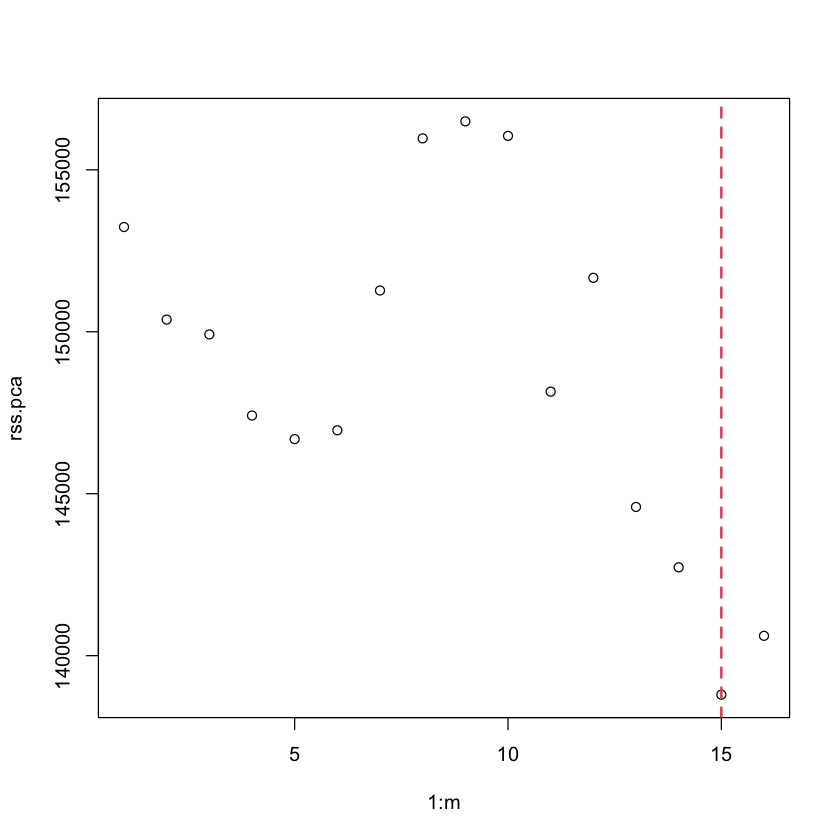

In [64]:
# fitting regression model to principal components in decreasing order

M <- ncol(Z)
rss.pca <- rep(0, M)
for (m in 1:M) {
    hitters.pca = data.frame(Z = Z[, 1:m], League = hitters$League, Division = hitters$Division, NewLeague = hitters$NewLeague, Salary = hitters$Salary)
    fit.pca = lm(Salary ~ . , data = hitters.pca[train, ])
    pred.pca = predict(fit.pca, newdata = hitters.pca[test, ])
    rss.pca[m] = mean((hitters.pca$Salary[test] - pred.pca)^2)
}

par(bg = "white")
plot(1:m, rss.pca)
abline(v = which.min(rss.pca), col = 2, lty = 2, lwd = 2)